## Pair Programming - Regresión logística 5

### Decision Tree

---

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('../archivos/travel_balanceado_sin_dupl.csv', index_col=0)
df.head(2)

,product_name,net_sales,commision_(in_value),continent,cat_age,cat_duration,net_sales_stand,commision_(in_value)_stand,agency_ADM,agency_ART,...,agency_TST,agency_TTW,agency_type_Airlines,agency_type_Travel Agency,distribution_channel_Offline,distribution_channel_Online,gender_F,gender_M,gender_PNS,claim
0,14,21.0,0.0,6,6,5,-0.431903,-0.516562,0,0,...,0,0,0,1,0,1,0,0,1,0
1,9,20.0,0.0,6,6,8,-0.451726,-0.516562,0,0,...,0,0,0,1,0,1,0,0,1,0


In [8]:
#Borramos las variables predictoras sin estandarizar
df_stand_bal = df.drop(['net_sales', 'commision_(in_value)'], axis= 1)

**Objetivos**:
### 1. Ajustad un modelo de Decision Tree a nuestros datos.

In [9]:
# Seaparamos los datos
X1 = df_stand_bal.drop("claim", axis = 1)
y1 = df_stand_bal["claim"]

In [10]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [11]:
# Usamos el metodo DecisionTreeClassifier y fiteamos
arbol = DecisionTreeClassifier(random_state =0)

arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

In [12]:
max_features = np.sqrt(len(x_train1.columns))
max_features

5.385164807134504

In [13]:
print(arbol.tree_.max_depth)

31


In [14]:
# Definimos los hiperparámetros
param = {"max_depth": [2, 4, 6], 
        "max_features": [1,2,3,4,5],
        "min_samples_split": [30, 50, 100],
        "min_samples_leaf": [30, 50, 100]} 

In [15]:
# Usamos el método GridSearchCV
gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), 
            param_grid= param, 
            cv=10, 
            verbose=-1) 

In [16]:
# Ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [30, 50, 100],
                         'min_samples_split': [30, 50, 100]},
             verbose=-1)

In [17]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=6, max_features=2, min_samples_leaf=30,
                       min_samples_split=30, random_state=42)

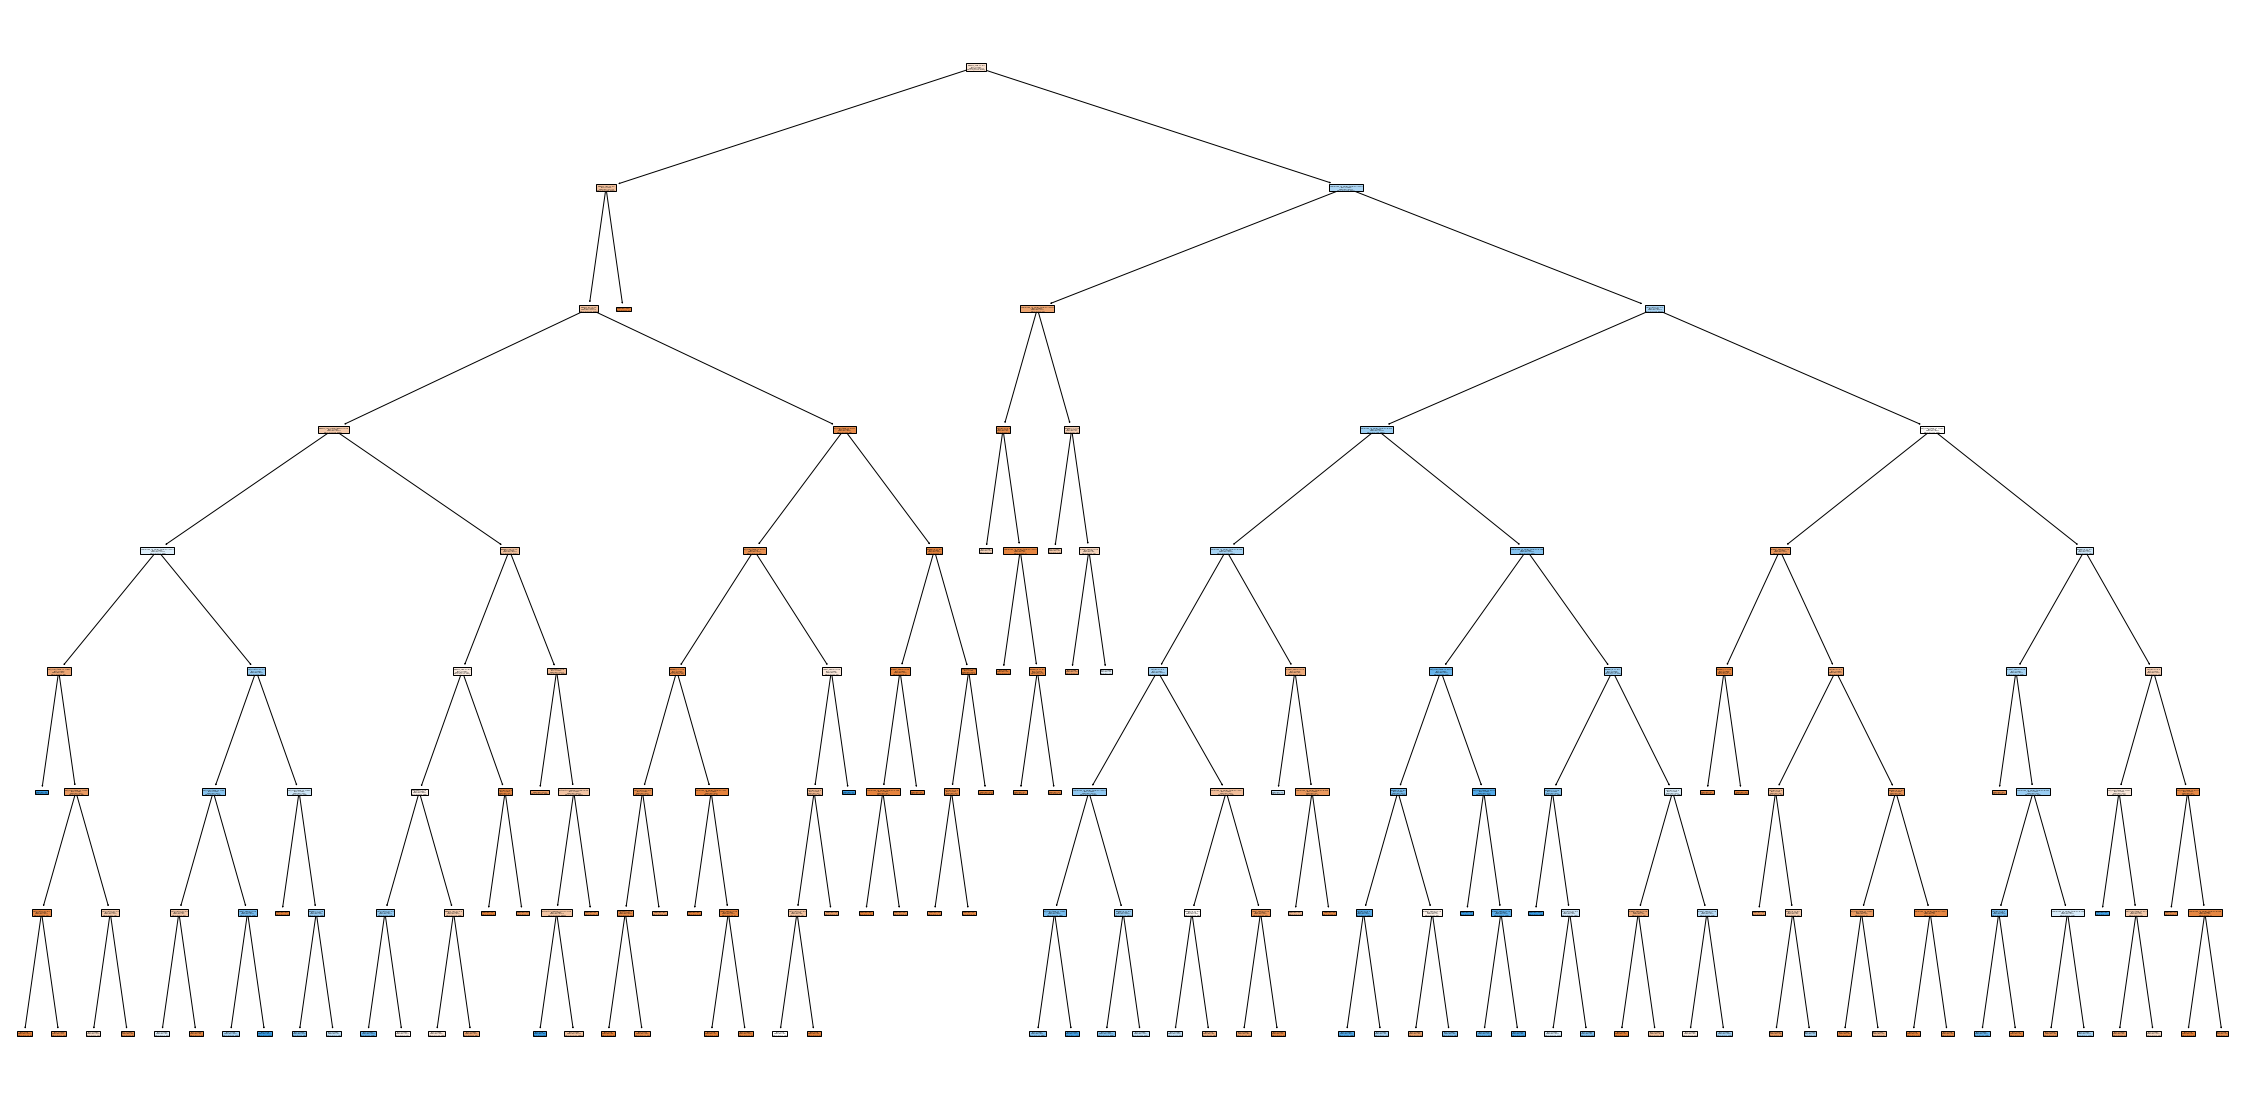

In [33]:
# Sacamos la visual de nuestro arbol
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train1.columns, filled=True);

In [18]:
# Sacamos las predicciones
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

### 2. Calculad las métricas a nuestro nuevo modelo.

In [19]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # Para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # Para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kappa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [20]:
# Sacamos las métricas

dt_results = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Stand_Bal I")
dt_results

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.895892,0.879437,0.871966,0.875686,0.786136,test,Decission Tree Stand_Bal I
1,0.975440,1.000000,0.943039,0.970685,0.949584,train,Decission Tree Stand_Bal I


En el primer decision tree las métricas nos mostraban overfitting por lo que bajamos la profundidad de 12 a 8, en el segundo intento nos seguían saliendo las mismas métricas, y decidimos bajar de nuevo la profundidad y aumentar el split y leaf, aún así nos sigue dando overfitting.

### 3. Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [21]:
resultados_anteriores = pd.read_csv('../archivos/resultados_travel_logistica.csv', index_col=0)

In [22]:
resultados_todo = pd.concat([resultados_anteriores, dt_results  ], axis = 0)
resultados_todo

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.729013,0.731073,0.562500,0.635802,0.425813,test,Regresión logistica Stan_Bal
1,0.733031,0.749612,0.571830,0.648762,0.439668,train,Regresión logistica Stan_Bal
0,0.985801,0.000000,0.000000,0.000000,-0.000180,test,Regresión logistica Sin Stan-Bal
1,0.982635,0.000000,0.000000,0.000000,-0.000135,train,Regresión logistica Sin Stan-Bal
0,0.728502,0.730284,0.561893,0.635117,0.424732,test,Regresión logistica Sin Stan Con Bal
1,0.732712,0.749660,0.570647,0.648017,0.438885,train,Regresión logistica Sin Stan Con Bal
0,0.985801,0.000000,0.000000,0.000000,-0.000180,test,Regresión logistica Con Stan Sin Bal
1,0.982635,0.000000,0.000000,0.000000,-0.000135,train,Regresión logistica Con Stan Sin Bal
0,0.895892,0.879437,0.871966,0.875686,0.786136,test,Decission Tree Stand_Bal I
1,0.975440,1.000000,0.943039,0.970685,0.949584,train,Decission Tree Stand_Bal I


De todos los resultados vemos que ninguno es especialmente bueno, si tuvieramos que destacar alguno, sería Decission Tree pero tiene overfitting asique probablemente la mejor opción sería seguir haciendo ajustes y pruebas en la parte de los hiperparámetros.

In [23]:
resultados_todo.to_csv("../archivos/resultados_travel_log+DC.csv")